In [2]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)

x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")


reduction_train_ratio = 0.4

x_train, x_reduction, y_train, y_reduction = train_test_split(x_train, y_train, test_size=reduction_train_ratio, random_state=42)
print("Conjunto de treino reduzido em 80%")

# add the extra x_reduction and y_reduction to the x_test and y_test
#x_test = np.concatenate((x_test, x_reduction), axis=0)
#y_test = np.concatenate((y_test, y_reduction), axis=0)
#print("Dados adicionados ao conjunto de teste")

x_validation = np.concatenate((x_validation, x_reduction), axis=0)
y_validation = np.concatenate((y_validation, y_reduction), axis=0)
print("Dados adicionados ao conjunto de validacao")

print(f"Total de imagens no conjunto de treino: {x_train.shape[0]}")
print(f"Total de imagens no conjunto de validação: {x_validation.shape[0]}")
print(f"Total de imagens no conjunto de teste: {x_test.shape[0]}")


# Contando as imagens por classe no conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Contagem de imagens por classe no conjunto de treino:")
for i, category in enumerate(categories):
    print(f" - {category}: {counts[np.where(unique == i)[0][0]] if i in unique else 0}")

# Contando as imagens por classe no conjunto de validação
unique, counts = np.unique(y_validation, return_counts=True)
print("Contagem de imagens por classe no conjunto de validação:")
for i, category in enumerate(categories):
    print(f" - {category}: {counts[np.where(unique == i)[0][0]] if i in unique else 0}")

# Contando as imagens por classe no conjunto de teste
unique, counts = np.unique(y_test, return_counts=True)
print("Contagem de imagens por classe no conjunto de teste:")
for i, category in enumerate(categories):
    print(f" - {category}: {counts[np.where(unique == i)[0][0]] if i in unique else 0}")

Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categories.
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Category: targetspot from subfolder Tomato___Targetspot is not in the list of categories.
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Category: earlyblight from subfolder Tomato___Earlyblight is not in the list of categor

In [25]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

def create_cnn_model(dropout_rate, learning_rate):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

    for layer in base_model.layers:
        layer.trainable = False

    # Tornar as últimas n camadas treináveis
    n_trainable_layers = 3
    for layer in base_model.layers[-n_trainable_layers:]:
        layer.trainable = True
        
    x = base_model.output
    x = Flatten()(x) 
    x = Dense(128, activation='relu')(x)  
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(len(categories), activation='softmax')(x)  # Output layer

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/60
225/225 [==============================] - 4s 15ms/step - loss: 0.9305 - accuracy: 0.6890 - val_loss: 1.8959 - val_accuracy: 0.5300

Epoch 00001: val_accuracy improved from -inf to 0.53000, saving model to best_model.h5
Epoch 2/60
225/225 [==============================] - 3s 13ms/step - loss: 0.3567 - accuracy: 0.8942 - val_loss: 6.2793 - val_accuracy: 0.3229

Epoch 00002: val_accuracy did not improve from 0.53000
Epoch 3/60
225/225 [==============================] - 3s 14ms/step - loss: 0.2626 - accuracy: 0.9204 - val_loss: 0.4798 - val_accuracy: 0.8511

Epoch 00003: val_accuracy improved from 0.53000 to 0.85113, saving model to best_model.h5
Epoch 4/60
225/225 [==============================] - 3s 13ms/step - loss: 0.2016 - accuracy: 0.9324 - val_loss: 0.8320 - val_accuracy: 0.7778

Epoch 00004: val_accuracy did not improve from 0.85113
Epoch 5/60
225/225 [==============================] - 3s 13ms/step - loss: 0.1569 -

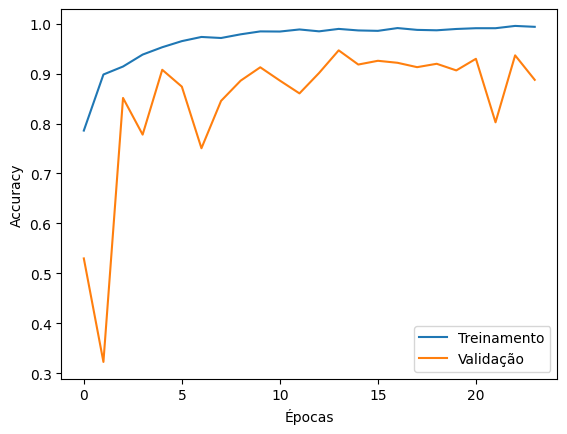

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

best_learning_rate = 0.001
dropout_rate = 0.325

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, mode='min', verbose=1)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=60, batch_size=32, verbose=1, validation_data=(x_validation, y_validation),callbacks=[early_stopping, model_checkpoint])

best_pso_train_accuracy = best_model_history.history['accuracy'][-1]
best_pso_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treino: ", best_pso_train_accuracy)
print("Melhor Accuracy de Validação: ", best_pso_validation_accuracy)


# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

best_model = load_model('best_model.h5') 


In [35]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.9487500190734863, Loss: 0.2685680687427521


In [36]:
import uuid

# Formatar a acurácia para obter as três primeiras casas decimais
formatted_accuracy = int(test_accuracy * 1000)
# Gerar um GUID único para o nome do arquivo
unique_filename = str(uuid.uuid4())
# Salve o modelo com o nome de arquivo GUID e a acurácia formatada
best_model.save(f'model_{formatted_accuracy}_{unique_filename}.h5')


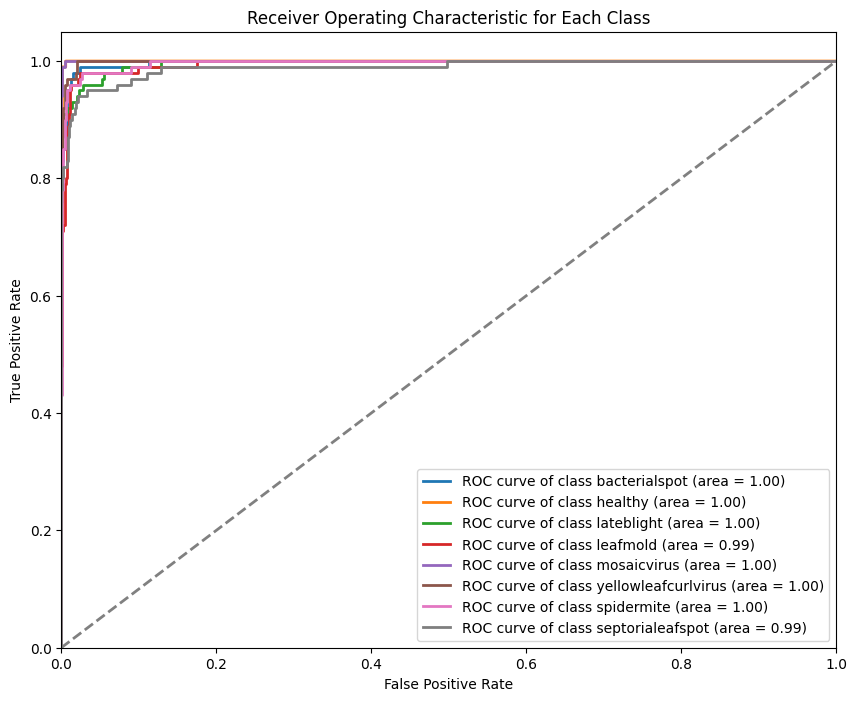

In [33]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Binarize as etiquetas em um formato one-vs-all
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))

# Calcular a curva ROC e AUC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, category in enumerate(categories):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotar a curva ROC para cada classe
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve of class {category} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc="lower right")
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Obtenha as previsões do modelo
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calcule a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Converta a matriz de confusão em percentagens
conf_matrix_percent = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

# Exibir a matriz de confusão
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2%", cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("Matriz de Confusão (Percentagens por Classe)")
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Prevista')
plt.show()


ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.5.
Please upgrade numpy to >= 1.20.3 to use this pandas version

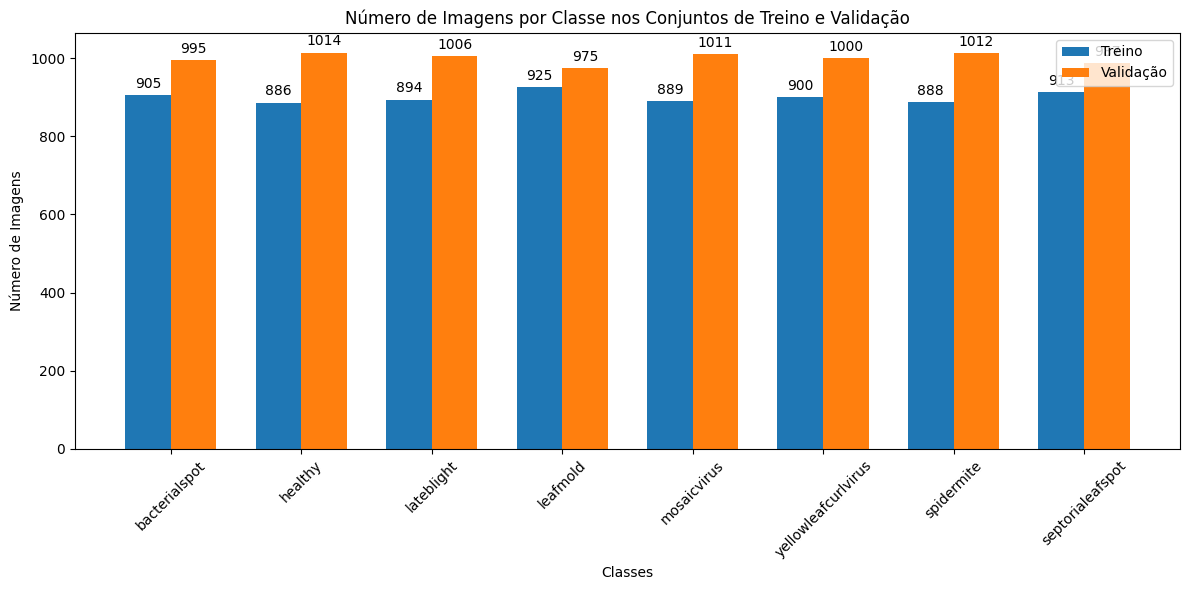

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Suponha que 'y_train' e 'y_validation' são seus rótulos de treino e validação
# 'categories' é a lista com os nomes das classes

# Contar o número de imagens por classe nos conjuntos de treino e validação
train_counts = np.bincount(y_train)
validation_counts = np.bincount(y_validation)

# Certificar-se de que há contagens para cada classe
train_counts = np.pad(train_counts, (0, len(categories) - len(train_counts)), 'constant')
validation_counts = np.pad(validation_counts, (0, len(categories) - len(validation_counts)), 'constant')

# Criar gráficos de barras
x = np.arange(len(categories))  # localizações das etiquetas
width = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(12, 6))  # Gráfico mais largo
rects1 = ax.bar(x - width/2, train_counts, width, label='Treino')
rects2 = ax.bar(x + width/2, validation_counts, width, label='Validação')

# Adicionar rótulos, título e legendas
ax.set_xlabel('Classes')
ax.set_ylabel('Número de Imagens')
ax.set_title('Número de Imagens por Classe nos Conjuntos de Treino e Validação')
ax.set_xticks(x)
ax.set_xticklabels(categories, rotation=45)  # Rotação dos rótulos para melhorar a visualização
ax.legend()

# Função para exibir as etiquetas
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
